In [1]:
#importing libraries
!pip install torch 
!pip install torchvision
!pip install imblearn
!pip install sklearn
import os
import random
from tqdm import tqdm
import numpy as np
import torch, torchvision
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset   

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

%matplotlib inline

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from numpy import vstack
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.optim import SGD
from torch.nn import BCELoss

In [2]:
# Read the Synthetic identity dataset in the dataframe
# data = pd.read_csv('drive/MyDrive/labeled_database.csv')
data = pd.read_csv('labeled_database.csv')
data.head()

,Unnamed: 0,Name,DoB,Mobile,Email,Location,label
0,0,Abdul Samad S Thakur,21-Jan,9.146494e+09,info@marcopower.com,Mazgaon Mumbai 400010.0,0
1,1,ABHISHEK CHAURASIA,25-Aug,9.450721e+09,ABHISHEK9MARC@GMAIL.COM,UTTAR PRADESH MOHAMMADABAD 233227.0,0
2,2,ABHISHEK DWIVEDI,01-Jul,8.763206e+09,tejaswi_kunjir2422@rediff.com,ALLAHABAD GHOORPUR 212111.0,0
3,3,abhishek goel,12-Apr,9.422032e+09,spect002@yahoo.in,Narayan Peth Pune 411030.0,0
4,4,Abhishek Gupta,17-May,9.899800e+09,Abhinavdoit@sify.com,Sector 1 Noida 201301.0,0


1    171429
0       826
Name: label, dtype: int64

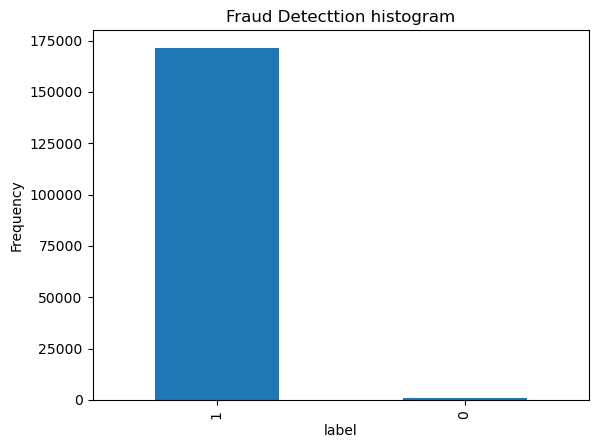

In [3]:
#print the lebels in the histogram to see frequecy
pd.value_counts(data['label']).plot.bar()
plt.title('Fraud Detecttion histogram')
plt.xlabel('label')
plt.ylabel('Frequency')
data['label'].value_counts()

In [4]:
import re
# Remove punctuation and apply case folding
def preprocessor(text):
    text = re.sub('<[^>]*>', '', str(text).lower())
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' .join(emoticons).replace('-', ''))

    return text

In [5]:
# apply the preprocessor to all columns

data['Name'] = data['Name'].apply(preprocessor)
data['DoB'] = data['DoB'].apply(preprocessor)
data['Mobile'] = data['Mobile'].apply(preprocessor)
data['Email'] = data['Email'].apply(preprocessor)
data['Location'] = data['Location'].apply(preprocessor)

data.head()

,Unnamed: 0,Name,DoB,Mobile,Email,Location,label
0,0,abdul samad s thakur,21 jan,9146494301 0,info marcopower com,mazgaon mumbai 400010 0,0
1,1,abhishek chaurasia,25 aug,9450720765 0,abhishek9marc gmail com,uttar pradesh mohammadabad 233227 0,0
2,2,abhishek dwivedi,01 jul,8763205964 0,tejaswi_kunjir2422 rediff com,allahabad ghoorpur 212111 0,0
3,3,abhishek goel,12 apr,9422032359 0,spect002 yahoo in,narayan peth pune 411030 0,0
4,4,abhishek gupta,17 may,9899799723 0,abhinavdoit sify com,sector 1 noida 201301 0,0


In [6]:
#to get the shape of the data
X = np.array(data.loc[:, data.columns != 'label'])
y = np.array(data.loc[:, data.columns == 'label'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))
X

Shape of X: (172255, 6)
Shape of y: (172255, 1)


array([[0, 'abdul samad s thakur', '21 jan', '9146494301 0',
        'info marcopower com', 'mazgaon mumbai 400010 0'],
       [1, 'abhishek chaurasia', '25 aug', '9450720765 0',
        'abhishek9marc gmail com', 'uttar pradesh mohammadabad 233227 0'],
       [2, 'abhishek dwivedi', '01 jul', '8763205964 0',
        'tejaswi_kunjir2422 rediff com', 'allahabad ghoorpur 212111 0'],
       ...,
       [172520, 'raju', '10 jun', '9811205236 0',
        'info ecocontrolsystems com', 'sector 63 noida 201307 0'],
       [172521, 'mr dinesh rastogi', '20 jan', '9820560707 0',
        'anujapackway rediffmail com', 'sector 7 noida 201304 0'],
       [172522, 'ashu garg', '10 jun', '9811291818 0',
        'vikas gupta1975 yahoo com', 'kalkaji delhi 110019 0']],
      dtype=object)

In [7]:
#feature selection
X_f = data['Name'] + data['DoB'] + data['Mobile'] + data['Email'] + data['Location']
X_f

0         abdul samad s thakur21 jan9146494301 0info mar...
1         abhishek chaurasia25 aug9450720765 0abhishek9m...
2         abhishek dwivedi01 jul8763205964 0tejaswi_kunj...
3         abhishek goel12 apr9422032359 0spect002 yahoo ...
4         abhishek gupta17 may9899799723 0abhinavdoit si...
                                ...                        
172250    dharmesh patel06 jul9811079705 0contact edworl...
172251    nirmal singh11 jun9223244209 0kamleshprince ho...
172252    raju10 jun9811205236 0info ecocontrolsystems c...
172253    mr dinesh rastogi20 jan9820560707 0anujapackwa...
172254    ashu garg10 jun9811291818 0vikas gupta1975 yah...
Length: 172255, dtype: object

In [8]:
print(X_f.shape)

(172255,)


In [9]:
##vectorization of the selected features
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(use_idf=True, norm = 'l2', smooth_idf = True)

vectorized_df= tfidf_vectorizer.fit_transform(X_f)
print(vectorized_df.shape[1])
print(vectorized_df.dtype)
print(type(vectorized_df))

# Name 172255, 813

16300
float64
<class 'scipy.sparse._csr.csr_matrix'>


In [10]:
 from sklearn.decomposition import TruncatedSVD        
pca = TruncatedSVD(n_components=32)                                
X = pca.fit_transform(vectorized_df)

print(X.shape)
X

(172255, 32)


array([[ 2.75073328e-02,  2.37547452e-02, -8.28739377e-03, ...,
         1.02482670e-02,  1.24232781e-05, -4.14011960e-03],
       [ 3.36514360e-02,  2.44470837e-02,  8.24731407e-03, ...,
        -4.75066658e-03,  1.42257607e-01,  1.91603544e-02],
       [ 4.08502495e-03,  3.71034617e-03, -7.03614157e-04, ...,
         6.83438275e-03, -3.23997131e-03,  1.26896515e-03],
       ...,
       [ 1.81083443e-01, -1.17938249e-01, -1.10852480e-02, ...,
         7.64502700e-02,  1.93670703e-02, -3.52573822e-02],
       [ 1.73760610e-01, -8.24339295e-02, -1.65007609e-02, ...,
        -2.23256063e-02,  3.73359965e-02,  3.11325058e-02],
       [ 6.47350104e-02,  4.80361820e-02, -2.13757818e-02, ...,
        -3.66915950e-02, -5.24808952e-03, -9.13926524e-03]])

# Smote for oversampling

In [11]:
print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

#to deal with the oversmapling smote is used
sm = SMOTE(random_state=2)
X_smote, y_smote = sm.fit_resample(X, y.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_smote.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_smote==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote==0)))

Before OverSampling, counts of label '1': [171429]
Before OverSampling, counts of label '0': [826] 

After OverSampling, the shape of train_X: (342858, 32)
After OverSampling, the shape of train_y: (342858,) 

After OverSampling, counts of label '1': 171429
After OverSampling, counts of label '0': 171429


In [12]:
from sklearn.utils import shuffle

X_smote, y_smote = shuffle(X_smote, y_smote)
print(y_smote[0:1000])

[0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1
 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1
 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1
 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0
 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1
 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1
 1 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0
 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0
 0 0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1
 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1
 0 0 0 0 1 1 0 1 1 1 1 1 

In [13]:
#split the data in test and train in 20:80 ration and thier shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=0)

print("Number of identities X_train dataset: ", X_train.shape)
print("Number of identities y_train dataset: ", y_train.shape)
print("Number of identities X_test dataset: ", X_test.shape)
print("Number of identities y_test dataset: ", y_test.shape)

Number of identities X_train dataset:  (120578, 32)
Number of identities y_train dataset:  (120578, 1)
Number of identities X_test dataset:  (51677, 32)
Number of identities y_test dataset:  (51677, 1)


In [14]:
#split the smote data in test and train in 20:80 ration and thier shape
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size = 0.30, random_state=0)

print("Number of identities X_train dataset: ", X_train_smote.shape)
print("Number of identities y_train dataset: ", y_train_smote.shape)
print("Number of identities X_test dataset: ", X_test_smote.shape)
print("Number of identities y_test dataset: ", y_test_smote.shape)

Number of identities X_train dataset:  (240000, 32)
Number of identities y_train dataset:  (240000,)
Number of identities X_test dataset:  (102858, 32)
Number of identities y_test dataset:  (102858,)


In [1]:
# train data without smote

y_train_res = y_train.reshape(-1, 1) # reshaping y_train to (,1)
data_res = np.concatenate((X_train, y_train_res), axis = 1)

columnNames=["Type%d" % (i+1) for i in range(data_res.shape[1])]
np.savetxt('synid_train.csv', data_res, delimiter=",", comments='', header=','.join(columnNames))

NameError: name 'y_train' is not defined

In [16]:
# test data without smote

y_test_res = y_test.reshape(-1, 1) # reshaping y_test to (,1)
data_res = np.concatenate((X_test, y_test_res), axis = 1)
columnNames=["Type%d" % (i+1) for i in range(data_res.shape[1])]
np.savetxt('synid_test.csv', data_res, delimiter=",", comments='', header=','.join(columnNames))

In [17]:
# train data with smote

y_train_sm = y_train_smote.reshape(-1, 1) # reshaping y_train to (,1)
data_res = np.concatenate((X_train_smote, y_train_sm), axis = 1)
columnNames=["Type%d" % (i+1) for i in range(data_res.shape[1])]
np.savetxt('synid_train_SMOTE.csv', data_res, delimiter=",", comments='', header=','.join(columnNames))

In [18]:
# test data with smote

y_test_sm = y_test_smote.reshape(-1, 1) # reshaping y_test to (,1)
data_res = np.concatenate((X_test_smote, y_test_sm), axis = 1)
columnNames=["Type%d" % (i+1) for i in range(data_res.shape[1])]
np.savetxt('synid_test_SMOTE.csv', data_res, delimiter=",", comments='', header=','.join(columnNames))

# Model code

In [19]:
#function to process data in float
class PeopleDataset(T.utils.data.Dataset):
    def __init__(self, src_file, num_rows=None):
        df = pd.read_csv(src_file)
#         n = 137796  (without smote)
#         n = 274272
#         df = df1.head(n)
        print(df.columns)
        df.label = df.label.astype('float64')
        y_tmp = df['label'].values
        x_tmp = df.drop('label', axis=1).values
                

        self.x_data = T.tensor(x_tmp,dtype=T.float64).to(device)
        self.y_data = T.tensor(y_tmp,dtype=T.float64).to(device)

        print(type(self.x_data))
        print(len(self.x_data))

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        if T.is_tensor(idx):
            idx = idx.tolist()
        preds = self.x_data[idx].type(T.FloatTensor)
        pol = self.y_data[idx].type(T.LongTensor)
        sample = [preds, pol]
        return sample

In [31]:
mp = {}
mp_logistic = {}
mp['mp_logistic'] = mp_logistic

In [68]:
#model nueral network
#can be used any other model too
input_size = 32
class MLPUpdated(nn.Module):
    def __init__(self):
        super(MLPUpdated, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
    
    
#Logistic regression
# nn.Linear(input_size, 1)
# nn.Sigmoid()

In [69]:
#lists to store evaluation data
fed_acc, fed_pre, fed_recall, fed_f1 = list(), list(), list(), list()

# federated learning

In [83]:
# Can be changed to 12,16,24,32
num_clients = 32
# Change it to 3, 6, 10, 16
num_selected = 16
num_rounds = 3
epochs = 5
batch_size = 1024
device = "cpu"
device = torch.device(device)
fed_acc, fed_pre, fed_recall, fed_f1 = list(), list(), list(), list()
     

In [84]:
# Dividing the training data into num_clients, with each client having equal number of data
traindata = PeopleDataset('synid_train_SMOTE.csv')
# traindata = PeopleDataset(X_train_res, y_train_res)
print(len(traindata))
traindata_split = torch.utils.data.random_split(traindata, [int(len(traindata) / num_clients) for _ in range(num_clients)])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]
print(len(train_loader))


test_ds = PeopleDataset('synid_test_SMOTE.csv')
test_loader = T.utils.data.DataLoader(test_ds,batch_size=batch_size, shuffle=True)
print(len(test_loader))

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', 'label'],
      dtype='object')
<class 'torch.Tensor'>
240000
240000
32
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', 'label'],
      dtype='object')
<class 'torch.Tensor'>
102858
101


In [85]:
def client_update(client_model, optimizer, train_loader, epoch=5):
    """
    This function updates/trains client model on client data
    """
    model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = client_model(data)
            binary_loss = torch.nn.BCEWithLogitsLoss()
            target = target.unsqueeze(1)
            target = target.float()
            loss = binary_loss(output, target)
            loss.backward()
            optimizer.step()
    return loss.item()

In [86]:
def server_aggregate(global_model, client_models):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

In [87]:
def test(global_model, test_loader):
    """This function test the global model on test data and returns test loss and test accuracy """
    model.eval()
    test_loss = 0
    correct = 0
    actuals, predictions = list(), list()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = global_model(data)
            binary_loss = torch.nn.BCEWithLogitsLoss()
            target = target.unsqueeze(1)
            target = target.float()
            test_loss += binary_loss(output, target)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            actual = target.numpy()
            pr = output.detach().numpy()
            pr = pr.round()
            predictions.append(pr)
            actuals.append(actual)

    test_loss /= len(test_loader.dataset)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    # calculate precision
    prescision = precision_score(actuals, predictions)
    # calculate recall
    recall = recall_score(actuals, predictions)
    # calculate f1
    f1 = f1_score(actuals, predictions)
    fed_acc.append(acc)
    fed_pre.append(prescision)
    fed_recall.append(recall)
    fed_f1.append(f1)
    print()
    print(confusion_matrix(actuals, predictions))
    return test_loss, acc, prescision, recall, f1

In [88]:

###########################################
#### Initializing models and optimizer  ####
############################################

#### global model ##########
# global_model =  MLPUpdated().cuda()
global_model = MLPUpdated().to(device)

############## client models ##############
# client_models = [ MLPUpdated().cuda() for _ in range(num_selected)]
client_models = [ MLPUpdated().to(device) for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.01) for model in client_models]
     

In [89]:

###### List containing info about learning #########
losses_train = []
losses_test = []
acc_train = []
acc_test = []
# Runnining FL

import time
start_time = time.time()
for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    # client update
    loss = 0
    for i in tqdm(range(num_selected)):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
    
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models)
    
    test_loss, acc, prescision, recall, f1= test(global_model, test_loader)
    losses_test.append(test_loss)
    acc_test.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f | test prescision: %0.3f | test recall: %0.3f | test f1: %0.3f' % (loss / num_selected, test_loss, acc, prescision, recall, f1))

print("--- %s seconds ---" % (time.time() - start_time))
# time[24]['fed'] = (time.time() - start_time)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]



[[47995  3605]
 [46050  5208]]
0-th round
average train loss 0.722 | test loss 0.000711 | test acc: 0.517 | test prescision: 0.591 | test recall: 0.102 | test f1: 0.173


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:22<00:00,  1.38s/it]



[[49266  2334]
 [48200  3058]]
1-th round
average train loss 0.718 | test loss 0.00071 | test acc: 0.509 | test prescision: 0.567 | test recall: 0.060 | test f1: 0.108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.28s/it]



[[49777  1823]
 [49068  2190]]
2-th round
average train loss 0.727 | test loss 0.00071 | test acc: 0.505 | test prescision: 0.546 | test recall: 0.043 | test f1: 0.079
--- 72.02158212661743 seconds ---


In [90]:
print(len(fed_acc))
print(len(fed_pre))
print(len(fed_recall))
print(len(fed_f1))

3
3
3
3


In [91]:
mp_logistic[num_selected] = {'fed_acc': fed_acc, 'fed_pre': fed_pre, 'fed_recall': fed_recall, 'fed_f1': fed_f1}
print(mp_logistic)
print(len(mp_logistic))

{3: {'fed_acc': [0.5152929281144879, 0.5047444049077369, 0.5024791460071166], 'fed_pre': [0.5814737331473733, 0.5980210265924552, 0.75], 'fed_recall': [0.09760427640563424, 0.018865347848140777, 0.002458152873697764], 'fed_f1': [0.16715111422939424, 0.03657683215130024, 0.004900245012250612]}, 6: {'fed_acc': [0.5016624861459488, 0.5016624861459488, 0.5016624861459488], 'fed_pre': [0.0, 0.0, 0.0], 'fed_recall': [0.0, 0.0, 0.0], 'fed_f1': [0.0, 0.0, 0.0]}, 10: {'fed_acc': [0.5276497695852534, 0.5255886756499252, 0.5161776429640864], 'fed_pre': [0.5377382465057179, 0.5649511744523621, 0.5746425357464253], 'fed_recall': [0.37153224862460493, 0.2088064302157712, 0.1121190838503258], 'fed_f1': [0.4394448098023606, 0.3049157443414099, 0.18762957279746653]}, 16: {'fed_acc': [0.517247078496568, 0.508701316377919, 0.5052305119679559], 'fed_pre': [0.5909451945988881, 0.5671364985163204, 0.5457263892349863], 'fed_recall': [0.10160365211284092, 0.059658980061648915, 0.04272503804284209], 'fed_f1': 

In [92]:
print(mp['mp_logistic'][num_selected])

{'fed_acc': [0.517247078496568, 0.508701316377919, 0.5052305119679559], 'fed_pre': [0.5909451945988881, 0.5671364985163204, 0.5457263892349863], 'fed_recall': [0.10160365211284092, 0.059658980061648915, 0.04272503804284209], 'fed_f1': [0.17339481613424115, 0.1079611650485437, 0.07924589748692804]}


In [95]:
print(mp['mp_logistic'][16])
len(mp['mp_logistic'][16])

{'fed_acc': [0.517247078496568, 0.508701316377919, 0.5052305119679559], 'fed_pre': [0.5909451945988881, 0.5671364985163204, 0.5457263892349863], 'fed_recall': [0.10160365211284092, 0.059658980061648915, 0.04272503804284209], 'fed_f1': [0.17339481613424115, 0.1079611650485437, 0.07924589748692804]}


4

In [96]:
print(mp['mp_logistic'][3])
len(mp['mp_logistic'][3])

{'fed_acc': [0.5152929281144879, 0.5047444049077369, 0.5024791460071166], 'fed_pre': [0.5814737331473733, 0.5980210265924552, 0.75], 'fed_recall': [0.09760427640563424, 0.018865347848140777, 0.002458152873697764], 'fed_f1': [0.16715111422939424, 0.03657683215130024, 0.004900245012250612]}


4

In [103]:
print(mp['mp_logistic'][3]['fed_acc'])
print(mp['mp_logistic'][6]['fed_acc'])
print(mp['mp_logistic'][10]['fed_acc'])
print(mp['mp_logistic'][16]['fed_acc'])

[0.5152929281144879, 0.5047444049077369, 0.5024791460071166]
[0.5016624861459488, 0.5016624861459488, 0.5016624861459488]
[0.5276497695852534, 0.5255886756499252, 0.5161776429640864]
[0.517247078496568, 0.508701316377919, 0.5052305119679559]


## Graphs

Number of Rounds:  3


[Text(0.5, 0, 'Rounds'), Text(0, 0.5, 'F1-Score')]

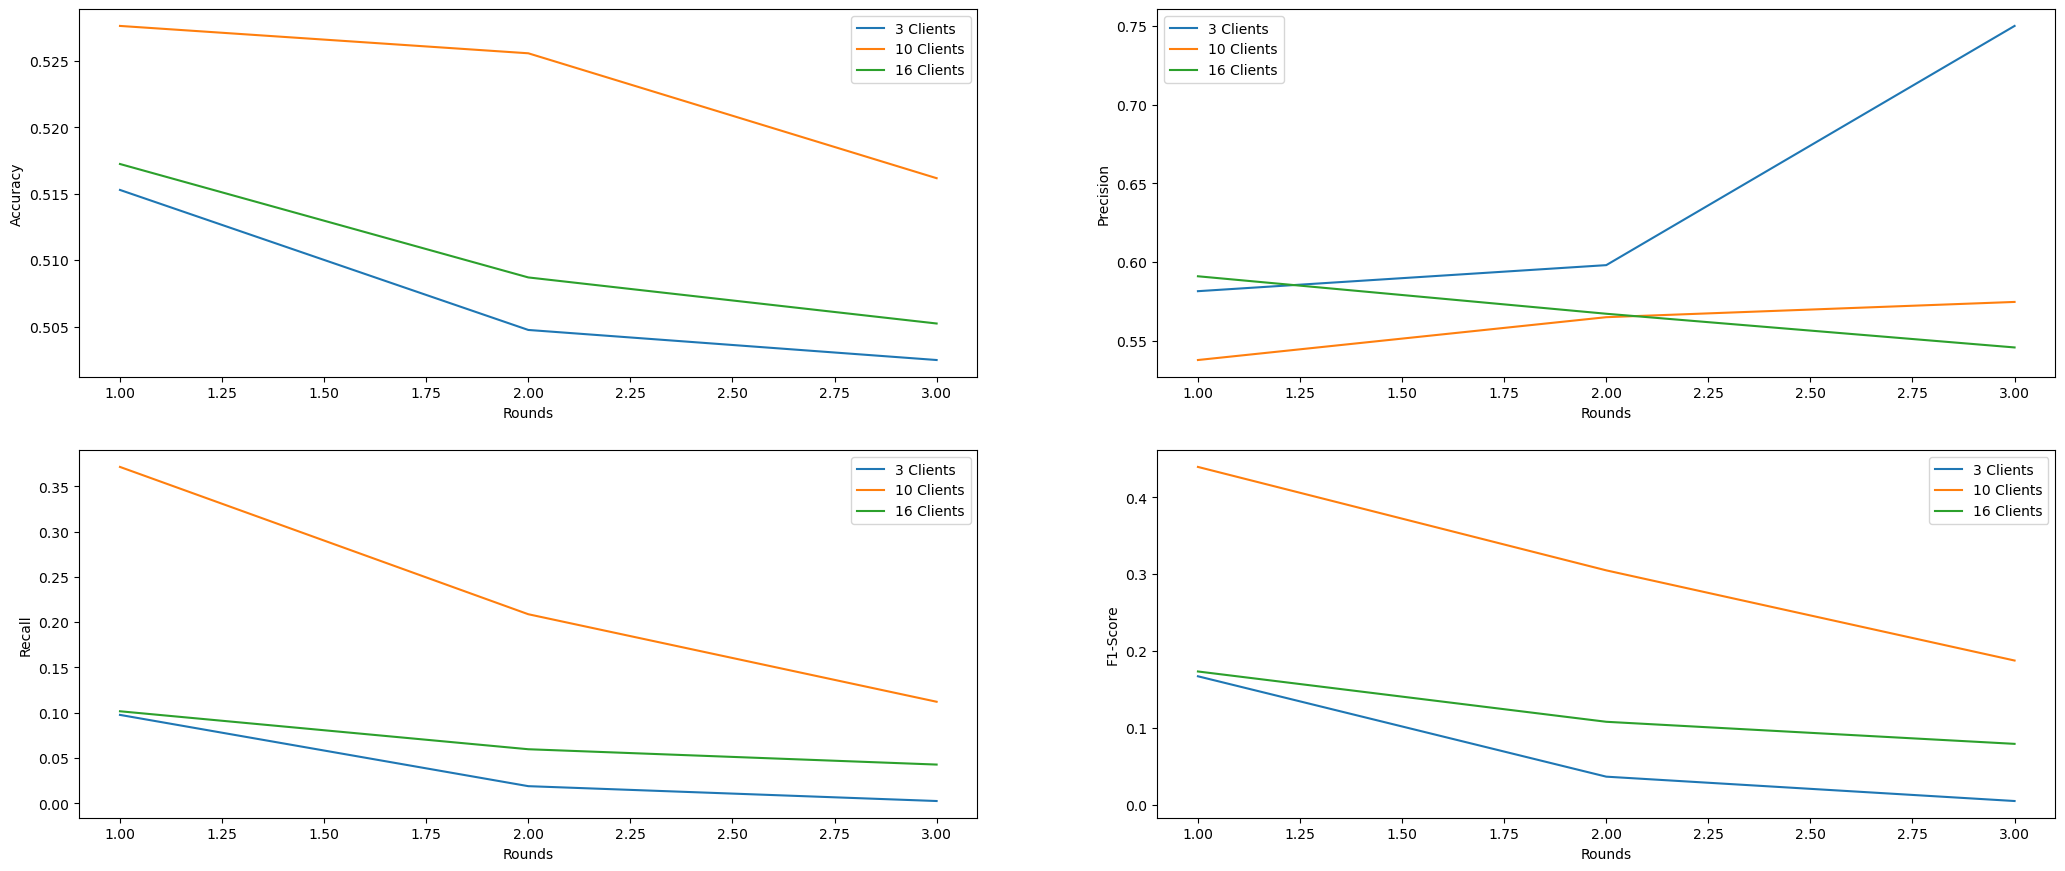

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
x = [i for i in range(1,4)]

print("Number of Rounds: ", 3)

fig, axs = plt.subplots(2,2)
fig.set_size_inches(25.5, 10.5)


sns.lineplot(x=x,y=mp['mp_logistic'][3]['fed_acc'], ax=axs[0][0], legend='brief', label="3 Clients")
# sns.lineplot(x=x,y=mp['mp_logistic'][6]['fed_acc'], ax=axs[0][0], legend='brief', label="6 Clients")
sns.lineplot(x=x,y=mp['mp_logistic'][10]['fed_acc'], ax=axs[0][0], legend='brief', label="10 Clients")
sns.lineplot(x=x,y=mp['mp_logistic'][16]['fed_acc'], ax=axs[0][0], legend='brief', label="16 Clients")
axs[0][0].set(xlabel="Rounds", ylabel = "Accuracy")

sns.lineplot(x=x,y=mp['mp_logistic'][3]['fed_pre'], ax=axs[0][1], legend='brief', label="3 Clients")
# sns.lineplot(x=x,y=mp['mp_logistic'][6]['fed_pre'], ax=axs[0][1], legend='brief', label="6 Clients")
sns.lineplot(x=x,y=mp['mp_logistic'][10]['fed_pre'], ax=axs[0][1], legend='brief', label="10 Clients")
sns.lineplot(x=x,y=mp['mp_logistic'][16]['fed_pre'], ax=axs[0][1], legend='brief', label="16 Clients")
axs[0][1].set(xlabel="Rounds", ylabel = "Precision")

sns.lineplot(x=x,y=mp['mp_logistic'][3]['fed_recall'], ax=axs[1][0], legend='brief', label="3 Clients")
# sns.lineplot(x=x,y=mp['mp_logistic'][6]['fed_recall'], ax=axs[1][0], legend='brief', label="6 Clients")
sns.lineplot(x=x,y=mp['mp_logistic'][10]['fed_recall'], ax=axs[1][0], legend='brief', label="10 Clients")
sns.lineplot(x=x,y=mp['mp_logistic'][16]['fed_recall'], ax=axs[1][0], legend='brief', label="16 Clients")
axs[1][0].set(xlabel="Rounds", ylabel = "Recall")

sns.lineplot(x=x,y=mp['mp_logistic'][3]['fed_f1'], ax=axs[1][1], legend='brief', label="3 Clients")
# sns.lineplot(x=x,y=mp['mp_logistic'][6]['fed_f1'], ax=axs[1][1], legend='brief', label="6 Clients")
sns.lineplot(x=x,y=mp['mp_logistic'][10]['fed_f1'], ax=axs[1][1], legend='brief', label="10 Clients")
sns.lineplot(x=x,y=mp['mp_logistic'][16]['fed_f1'], ax=axs[1][1], legend='brief', label="16 Clients")
axs[1][1].set(xlabel="Rounds", ylabel = "F1-Score")